<a href="https://colab.research.google.com/github/diegooo9/mat281_portfolio_2022/blob/master/labs/lab_10/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/labs/lab_10/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [20]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [21]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [23]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281_2022/main/labs/lab_10/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [24]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


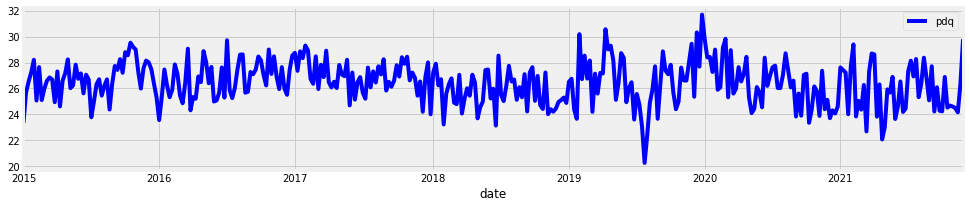

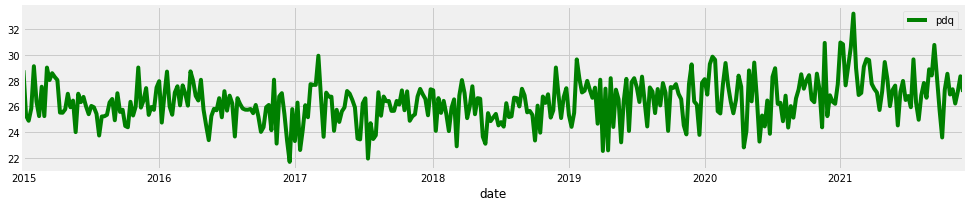

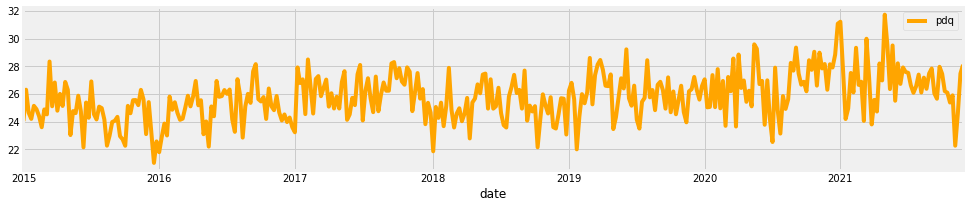

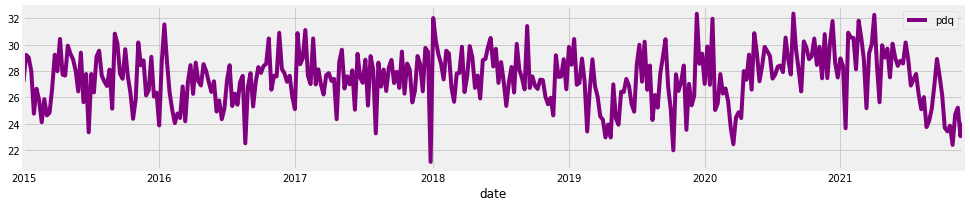

In [25]:
y_s1.plot(figsize=(15,3),color="blue")
y_s2.plot(figsize=(15,3),color="green")
y_s3.plot(figsize=(15,3),color="orange")
y_s4.plot(figsize=(15,3),color="purple")

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realizar un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [26]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

Descomposicion STL


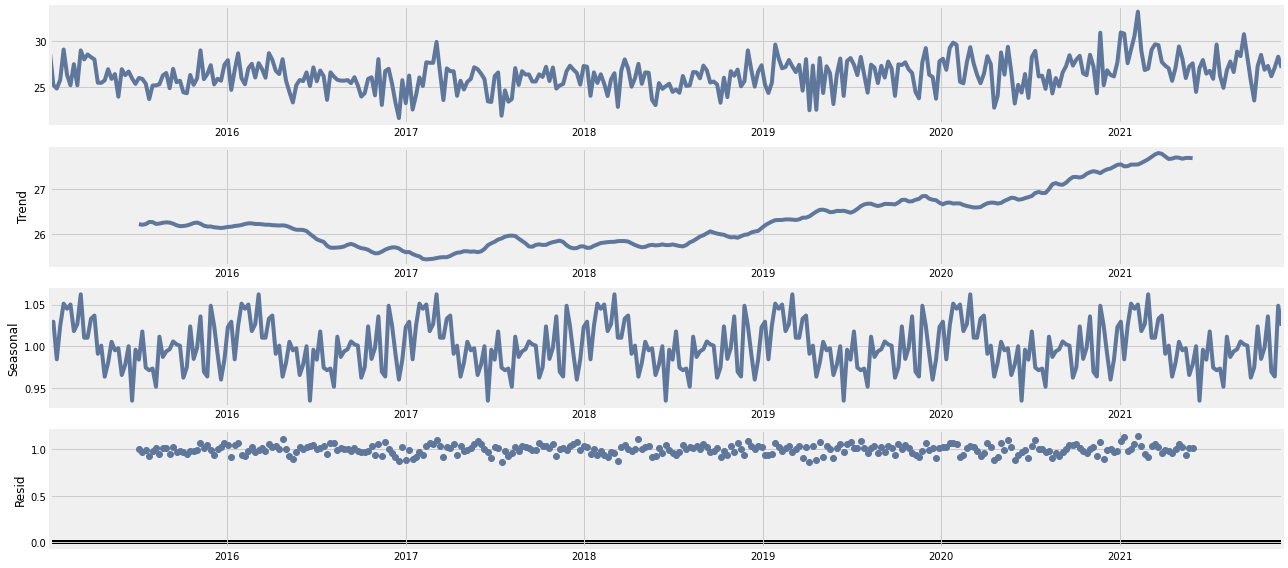

ACF
PACF


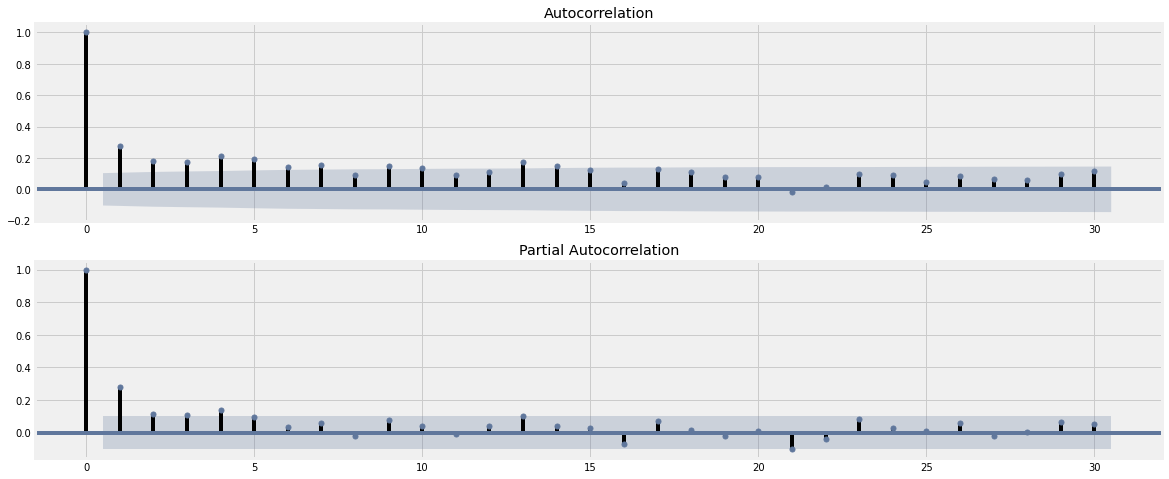

Resultados de la prueba de Dickey-Fulle
Test-Statistic                  -5.434942
p-value                          0.000003
#Lags Used                       4.000000
Number of Observations Used    356.000000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Resultados para cada modelo
        mae       mse     rmse    mape   maape   wmape   mmape   smape  \
0   27.7622  773.9341  27.8197  1.0000  0.7854  1.0000  0.9651  2.0000   
0   24.1010  618.8685  24.8771  0.8744  0.7022  0.8681  0.8436  1.6744   
0    1.9778    7.0173   2.6490  0.0703  0.0699  0.0712  0.0679  0.0715   
0    1.9204    6.0707   2.4639  0.0668  0.0665  0.0692  0.0645  0.0699   
0    2.0343    7.1918   2.6818  0.0722  0.0717  0.0733  0.0697  0.0739   
..      ...       ...      ...     ...     ...     ...     ...     ...   
0    1.5198    4.4674   2.1136  0.0530  0.0528  0.0547  0.0512  0.0547   
0    1.5314    4.2455   2.0605  0.0533  0.0532  0.0552  0.0515  0.0551   
0    1.5280    4.2301   2.0567  0.0532  0.0530  0.0550  0.0514  0.0550   
0    1.7964    5.8076   2.4099  0.0633  0.0630  0.0647  0.0612  0.0651   
0    1.4987    4.3802   2.0929  0.0523  0.0520  0.0540  0.0505  0.0539   

                        model  
0   SARIMA_(0,0,0)X(0,0,0,12)  
0   SARIMA_(0,0,0)X

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


                    y       yhat
2021-01-03  30.967742  26.626921
2021-01-10  30.833333  26.437524
2021-01-17  27.629032  26.963124
2021-01-24  29.114754  26.940624
2021-01-31  30.606061  27.082298
Grafico mejor modelo


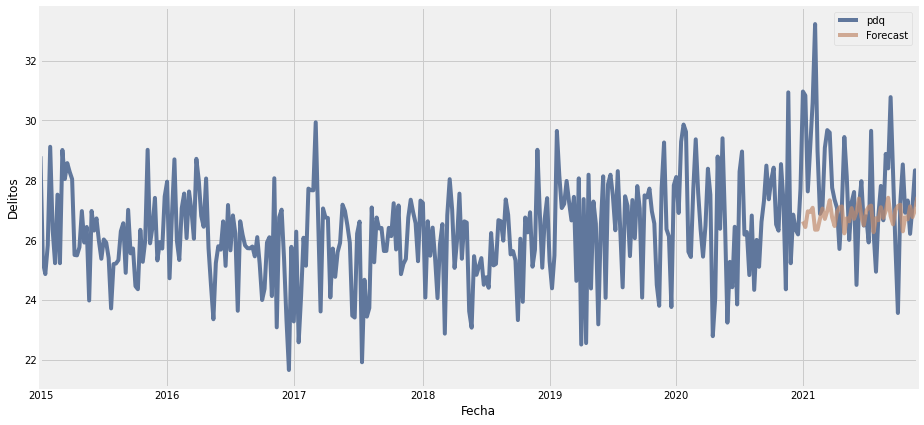

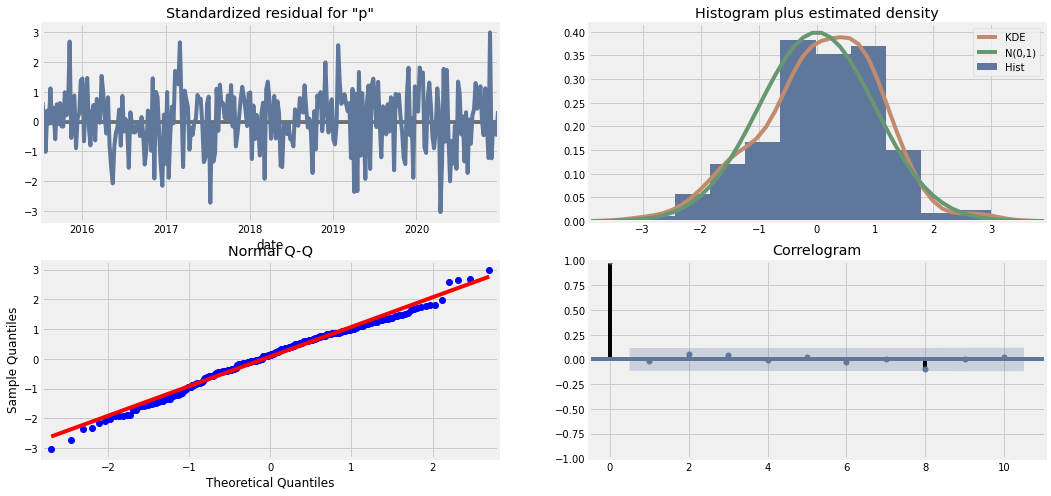

In [38]:
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller

#Descomposicion STL
print("Descomposicion STL")
rcParams["figure.figsize"]=18,8
descomposicion=sm.tsa.seasonal_decompose(y_s2,model="multiplicative")
fig =descomposicion.plot()
plt.show()

#acf
print("ACF")
pyplot.subplot(211)
plot_acf(y_s2, ax=pyplot.gca(),lags=30)

#pacf
print("PACF")
pyplot.subplot(212)
plot_pacf(y_s2, ax=pyplot.gca(),lags=30)
pyplot.show()

#Prueba Dickey-Fulle
print("Resultados de la prueba de Dickey-Fulle")
df_test=adfuller(y_s2,autolag="AIC")
df_output=pd.Series(df_test[0:4],index=["Test-Statistic","p-value","#Lags Used","Number of Observations Used"])
print(df_output)

#Iteracion
frames=[]
for param in params:
  try:
    sarima_model=SarimaModels(param)
    df_metrics=sarima_model.metrics(y_s2,target_date)
    frames.append(df_metrics)
  except:
    pass

#Juntamos los resultados de las metricas para cada modelo
print("Resultados para cada modelo")
df_metrics_result=pd.concat(frames)
df_metrics_result.sort_values(["mae","mape"],ascending=True)
print(df_metrics_result)

#Ajuste mejor modelo
print("Mejor modelo")
param=[(1,1,1),(1,1,1,12)]
sarima_model=SarimaModels(param)
model_fit=sarima_model.fit_model(y_s2,target_date)
best_model=sarima_model.df_testig(y_s2,target_date)
print(best_model.head())

#Grafico
print("Grafico mejor modelo")
prediccion=best_model["yhat"]
ax=y_s2["2015":].plot(label="observed")
prediccion.plot(ax=ax,label="Forecast",alpha=.7,figsize=(14,7))
ax.set_xlabel("Fecha")
ax.set_ylabel("Delitos")
plt.legend()
plt.show()

#Resultados del error
model_fit.plot_diagnostics(figsize=(16,8))
plt.show()

#Descomposicion STL
Es apreciable de los graficos obtenidos que las serie temporal no presenta una tendencia definida en todo su espectro temporal, mientras que se presenta una estacionariedad año a año.

#acf y pacf
Vemos que ambos graficos no descienden tan rapidamente al eje horizontal, pero si poseen una cierta velocidad considerable de descenso. Ante esta incertidumbre daremos paso a la prueba de "Dickey-Fuller".

#prueba de Dickey-Fuller
En base a lo obtenido de esta prueba, en particular al valor "p-value" que es muy cercano al cero, podemos concluir que la serie si es estacionaria.

#Mejor modelo
Es posible observar del dataframe correspondiente a los resultados de las metricas para cada modelo, alias "df_metrics_result", que el mejor modelo resulta ser SARIMA_(1,1,1)X(1,1,1,12).

#Grafico mejor modelo
Observamos que, a pesar de ser el mejor modelo, este tampoco se ajusta tan bien como uno quisiera a los datos.

#Resultados del error
De estos ultimos graficos podemos rescatar, en cada uno: 
        
        1)Nos muestra que el error  estandarizado, como serie de tiempo, oscila alrededor del cero. (grafico en la esquina izquierda superior)
          
        2)Vemos que el histograma se asemeja bastante a un histograma de una variable con distribucion normal. (grafico en la esquina derecha superior)

        3)Esta ajustada la serie, por lo que la distribucion es una semejante a una normal. (grafico en la esquina izquierda inferior)

        4)Notamos que el grafico indica una correlacion nula entre las variables. (grafico en la esquina derecha inferior)

En base a lo obtenido en cada grafico, podemos concluir que tratamos con un ruido blanco en el modelo.

3. Resuelva el ejercicio anterior utilizando la librería de `Prophet`.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgzjvfyxr/ubmad8ve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgzjvfyxr/aoef3uyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65077', 'data', 'file=/tmp/tmpgzjvfyxr/ubmad8ve.json', 'init=/tmp/tmpgzjvfyxr/aoef3uyg.json', 'output', 'file=/tmp/tmpgzjvfyxr/prophet_model289du1li/prophet_model-20221112194849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:48:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


DataFrame del Futuro
            ds       yhat
673 2021-12-23  26.987005
674 2021-12-24  27.006661
675 2021-12-25  27.033810
676 2021-12-26  27.067744
677 2021-12-27  27.107627
Resultado de las metricas
      mae     mse    rmse    mape   maape   wmape   mmape   smape
0  1.2731  2.9623  1.7211  0.0447  0.0446  0.0459  0.0432  0.0456


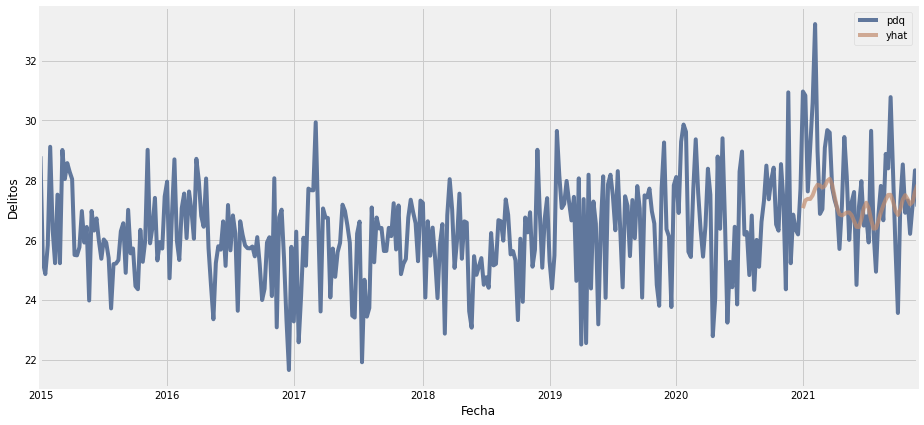

In [37]:
from prophet import Prophet
#Mask
mask_ds=y_s2.index<target_date
mask_ds2=y_s2.index>=target_date
y_train=y_s2[mask_ds]
y_test=y_s2[mask_ds2]

#Renombre
y_train_prophet=y_train.reset_index()
y_train_prophet.columns=["ds","y"]
y_test_prophet=y_test.reset_index()
y_test_prophet.columns=["ds","y"]

#Modelo
m=Prophet()
m.fit(y_train_prophet)

#Forecast
print("DataFrame del Futuro")
futuro=m.make_future_dataframe(periods=365)
forecast=m.predict(futuro)[["ds","yhat"]]
print(forecast.tail())

#Metricas
print("Resultado de las metricas")
result=y_test_prophet.merge(forecast,on="ds",how="inner")
print(summary_metrics(result))

#Grafico
preds=result[["ds","yhat"]].set_index("ds")
ax=y_s2["2015":].plot(label="observed")
preds.plot(ax=ax,label="Forecast",alpha=.7,figsize=(14,7))
ax.set_xlabel("Fecha")
ax.set_ylabel("Delitos")
plt.legend()
plt.show()

